# Captcha Solver

In [81]:
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import pickle
from keras.models import load_model

import char_detection
import preprocess
import model_definition
import utils

reload(char_detection)
reload(preprocess)
reload(model_definition)
reload(utils)

<module 'utils' from '/home/inesmcm/Desktop/projects/captcha-solver/src/utils.py'>

In [58]:
SIMPLE_CAPTCHA_FOLDER = '../data/simple_captcha'
SIMPLE_CHAR_FOLDER = '../data/simple_characters'
HARD_CAPTCHA_FOLDER = '../data/hard_captcha'
HARD_CHAR_FOLDER = '../data/hard_characters'

SIMPLE_LABEL_BINARIZER = '../models/one_hot/simple_label_binarizer.dat'
HARD_LABEL_BINARIZER = '../models/one_hot/hard_label_binarizer.dat'

SIMPLE_MODEL = '../models/CNN/simple_captcha_model.hdf5'
BASE_MODEL = '../models/CNN/base_captcha_model.hdf5'

## Hard Captcha Solver

### Images preprocessing

Whole captcha images are cropped into new images containing each character

In [12]:
char_detection.hard_imgs2char(HARD_CAPTCHA_FOLDER, HARD_CHAR_FOLDER)

Now we prepare the data for training by getting each preprocessed character image and respective labels

In [49]:
data, labels = preprocess.load_chars(HARD_CHAR_FOLDER)

In [50]:
data.shape

(86300, 20, 20, 1)

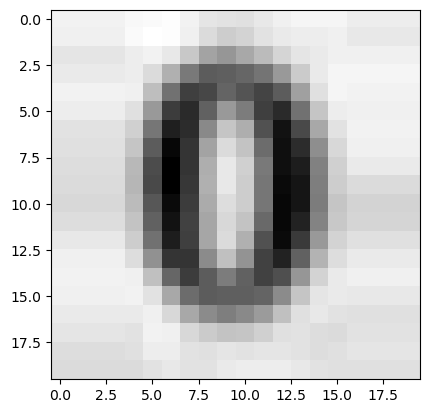

In [51]:
plt.imshow(data[0], cmap = 'gray')

The images should be normalized to achieve better performance

In [52]:
data = data / 255

The data is splitted into train, validation and test sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, random_state=0, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=0, stratify=y_train)

In order to train the multi-class classification model, each character needs to be converted to a one hot encode. To do that we use a LabelBinarizer and we save it to later decode the network's outputs.

In [54]:
y_train, y_val, y_test = preprocess.one_hot_labels(y_train, y_val, y_test, HARD_LABEL_BINARIZER)

Now, let's define the model and train it

In [55]:
model = model_definition.CNN()

In [56]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = 32, epochs = 5, verbose = 1)

Epoch 1/5
1517/1517 [==============================] - 177s 116ms/step - loss: 0.6661 - accuracy: 0.8472 - val_loss: 0.1828 - val_accuracy: 0.9583
Epoch 2/5
1517/1517 [==============================] - 181s 119ms/step - loss: 0.1505 - accuracy: 0.9682 - val_loss: 0.1121 - val_accuracy: 0.9750
Epoch 3/5
1517/1517 [==============================] - 178s 118ms/step - loss: 0.1029 - accuracy: 0.9780 - val_loss: 0.0951 - val_accuracy: 0.9778
Epoch 4/5
1517/1517 [==============================] - 174s 115ms/step - loss: 0.0744 - accuracy: 0.9836 - val_loss: 0.0766 - val_accuracy: 0.9845
Epoch 5/5
1517/1517 [==============================] - 167s 110ms/step - loss: 0.0580 - accuracy: 0.9870 - val_loss: 0.0804 - val_accuracy: 0.9838


In [59]:
model.save(BASE_MODEL)

In [60]:
model = load_model(BASE_MODEL, compile=False)

In [61]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics =['accuracy'])

In [62]:
model.evaluate(X_test, y_test, batch_size=32)

675/675 [==============================] - 17s 23ms/step - loss: 0.0882 - accuracy: 0.9842


[0.08821659535169601, 0.9842410087585449]

It looks like the model is well tuned. Let's see the results!

1/1 [==============================] - 0s 52ms/step
CAPTCHA text is yy4X1k8q6h


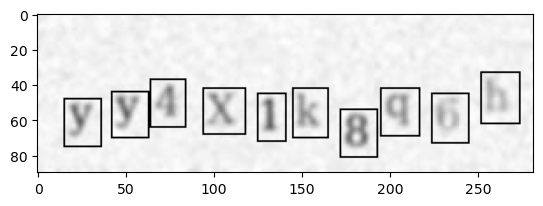

1/1 [==============================] - 0s 55ms/step
CAPTCHA text is dKOhwQ77XN


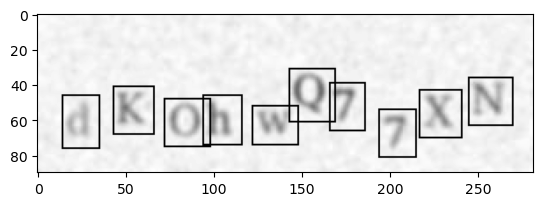

1/1 [==============================] - 0s 70ms/step
CAPTCHA text is 2o53V9mu5e


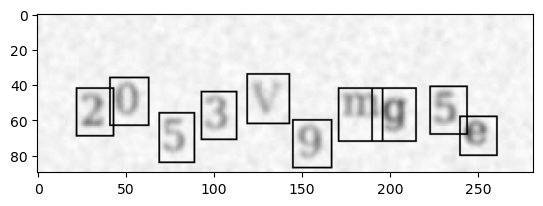

1/1 [==============================] - 0s 74ms/step
CAPTCHA text is wB17cxtdjO


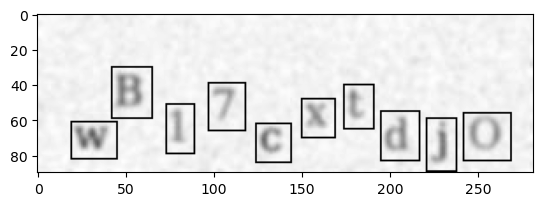

In [63]:
images = list(paths.list_images(HARD_CAPTCHA_FOLDER))
images = np.random.choice(images, size=(5,), replace=False)

# load label enconder
with open(HARD_LABEL_BINARIZER, 'rb') as f:
    lb = pickle.load(f)

for img_path in images:

    img, char_bound_box = char_detection.find_chars(img_path, simple = False)

    if char_bound_box is None:
        continue

    # img_bound_boxes = utils.draw_bound_boxes(img, char_bound_box)
    
    captcha_text = utils.img_predict(model, lb, char_bound_box)

    print("CAPTCHA text is {}".format(captcha_text))
    plt.imshow(img, cmap = 'gray')
    plt.show()

## Simple captcha solver

Now that we have a model working for hard captcha images, let's try to do transfer learning tp solver some simpler captchas.

#### Images preprocesssing

We repeat the process for the new images

In [ ]:
char_detection.simple_imgs2chars(SIMPLE_CAPTCHA_FOLDER, SIMPLE_CHAR_FOLDER)

In [65]:
data, labels = preprocess.load_chars(SIMPLE_CHAR_FOLDER)

In [66]:
data.shape

(38744, 20, 20, 1)

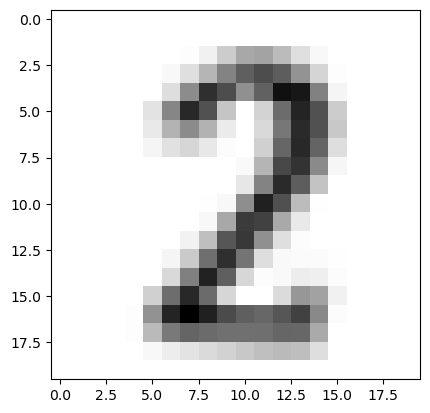

In [67]:
plt.imshow(data[0], cmap = 'gray')

In [68]:
data = data / 255

The data is splitted into train, validation and test sets

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.25, random_state=0, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=0, stratify=y_train)

In order to train the multi-class classification model, each character needs to be converted to a one hot encode. To do that we use a LabelBinarizer and we save it to later decode the network's outputs.

In [70]:
y_train, y_val, y_test = preprocess.one_hot_labels(y_train, y_val, y_test, SIMPLE_LABEL_BINARIZER)

Now let's get the base model traned before and the correspondent weights and add a new last trainable layer

In [91]:
model = model_definition.transfer_model(BASE_MODEL, out_len = 32)

In [92]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 20, 20, 20)        520       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 20)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 50)        25050     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1250)              0         
                                                                 
 dense_8 (Dense)             (None, 500)              

The new model only has 500 x 32 + 32 = 16.032 trainable parameters

In [93]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = 32, epochs = 3, verbose = 1)

Epoch 1/3
682/682 [==============================] - 22s 31ms/step - loss: 0.3167 - accuracy: 0.9406 - val_loss: 0.0370 - val_accuracy: 0.9934
Epoch 2/3
682/682 [==============================] - 21s 31ms/step - loss: 0.0303 - accuracy: 0.9939 - val_loss: 0.0217 - val_accuracy: 0.9944
Epoch 3/3
682/682 [==============================] - 20s 29ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.0161 - val_accuracy: 0.9957


In [94]:
model.save(SIMPLE_MODEL)

In [95]:
model = load_model(SIMPLE_MODEL)

It achieves a very good performance for training and validation. Let's see how it performs on the test set!

In [96]:
model.evaluate(X_test, y_test, batch_size=32)

303/303 [==============================] - 7s 21ms/step - loss: 0.0204 - accuracy: 0.9955


[0.020400673151016235, 0.9954573512077332]

The model seems to be well trained. Now, let's see it in action:

1/1 [==============================] - 0s 69ms/step
CAPTCHA text is 6E3A


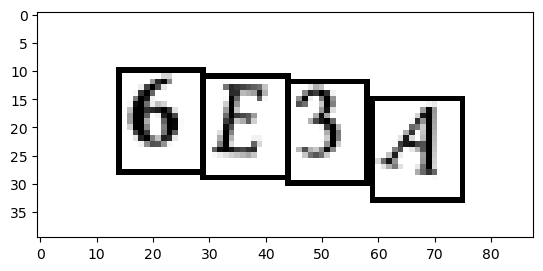

1/1 [==============================] - 0s 72ms/step
CAPTCHA text is 24FK


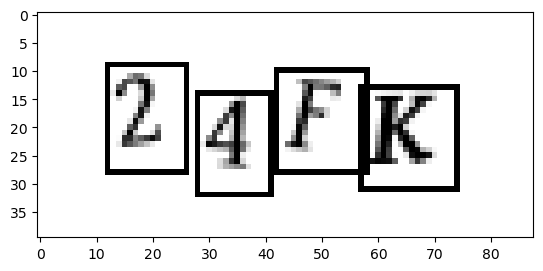

1/1 [==============================] - 0s 63ms/step
CAPTCHA text is 2CH4


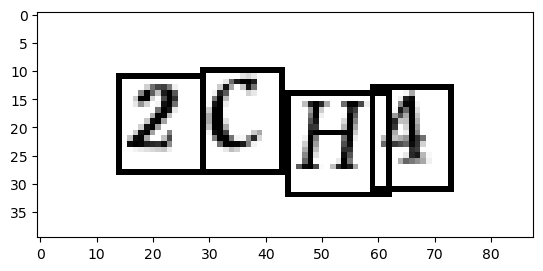

1/1 [==============================] - 0s 48ms/step
CAPTCHA text is FZCB


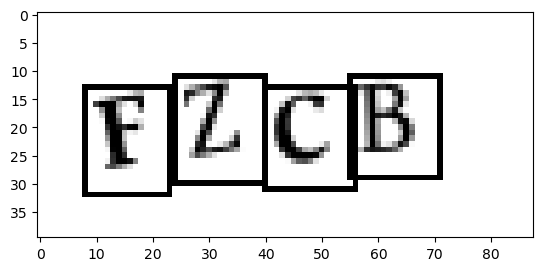

1/1 [==============================] - 0s 91ms/step
CAPTCHA text is YXFT


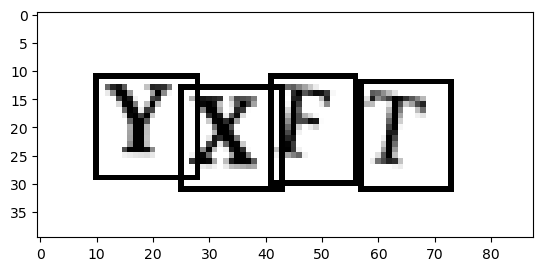

In [97]:
images = list(paths.list_images(SIMPLE_CAPTCHA_FOLDER))
images = np.random.choice(images, size=(5,), replace=False)

# load label enconder
with open(SIMPLE_LABEL_BINARIZER, 'rb') as f:
    lb = pickle.load(f)

for img_path in images:

    img, char_bound_box = char_detection.find_chars(img_path)

    if char_bound_box is None:
        continue

    # img_bound_boxes = utils.draw_bound_boxes(img, char_bound_box)
    
    captcha_text = utils.img_predict(model, lb, char_bound_box)

    print("CAPTCHA text is {}".format(captcha_text))
    plt.imshow(img, cmap = 'gray')
    plt.show()

We managed to use the feature extraction from the hardest captcha images to solve this much simpler problem!